# Yammer  ---- Yanchu Wang

### Read the events file, which seems to be the most important one

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
evt=pd.read_csv('yammer_events.csv')

In [3]:
evt['time']=(pd.to_datetime(evt.occurred_at)-pd.to_datetime("2013-01-01 20:59:28")).dt.days

In [4]:
evt.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type,time
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0,485
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0,485
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0,485
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0,485
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0,485


### reproduce the plot shown by the head

In [5]:
evt['week']=(evt.time)//7

(array([ 943., 1075., 1144., 1142., 1139., 1184., 1259., 1272., 1257.,
        1325., 1358., 1367., 1403., 1384., 1243., 1223., 1191.,  980.]),
 array([69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
        86, 87]),
 <a list of 18 Patch objects>)

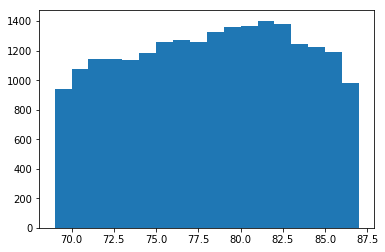

In [6]:
plt.hist(evt[evt.event_type=='engagement'][['user_id','location','week']].drop_duplicates().week,bins=range(evt.week.min(),evt.week.max()+2))

## Hypothesis 1: Regional effect? Regional policy or server down?

In [7]:
evt2=evt[(evt.event_type=='engagement')][['user_id','week','location']].drop_duplicates()

(array([39.,  5.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  65. ,  675.2, 1285.4, 1895.6, 2505.8, 3116. , 3726.2, 4336.4,
        4946.6, 5556.8, 6167. ]),
 <a list of 10 Patch objects>)

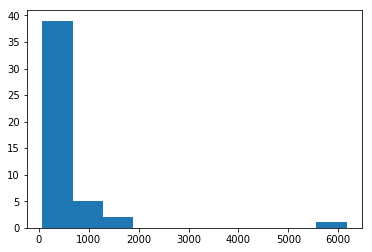

In [8]:
plt.hist(evt2.location.value_counts())

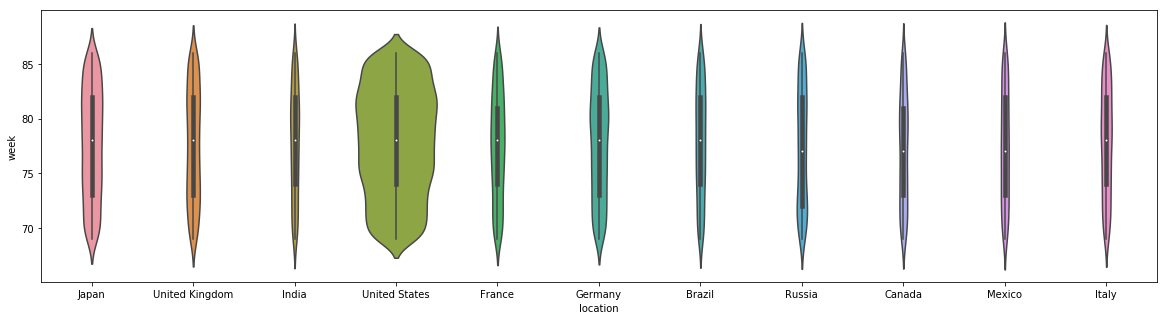

In [9]:
evt2=evt2[evt2.groupby('location')['week'].transform('count')>500]
plt.figure(figsize=(20,5))
sns.violinplot(x = 'location', y = 'week',data = evt2,scale="count")

(array([266., 291., 306., 297., 303., 318., 374., 373., 366., 373., 378.,
        383., 403., 406., 361., 340., 345., 284.]),
 array([69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
        86, 87]),
 <a list of 18 Patch objects>)

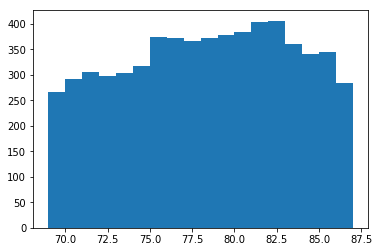

In [10]:
plt.hist(evt2[evt2.location=='United States'].week,bins=range(evt.week.min(),evt.week.max()+2))

### nothing much about the location, most of the users are in the US

## Hypothesis 2: Something related to the event name? Some service malfunctioning?

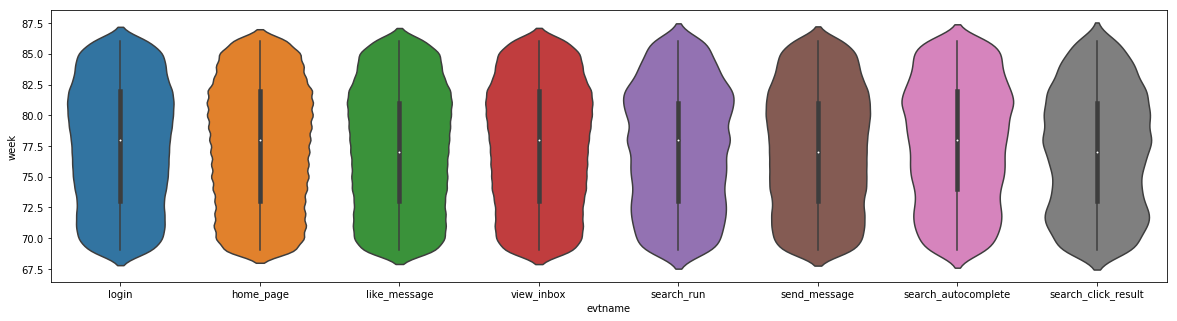

In [11]:
evt['evtname']=evt.event_name.apply(lambda x: ('search_click_result' if 'search_click_result_' in x else x))
plt.figure(figsize=(20,5))
sns.violinplot(x = 'evtname', y = 'week',data = evt[evt.event_type=='engagement'])

### The same trend across all the activities, unclear what's going on. Search_click_result activities seems to fall earlier and harder, comparing to others including search_run

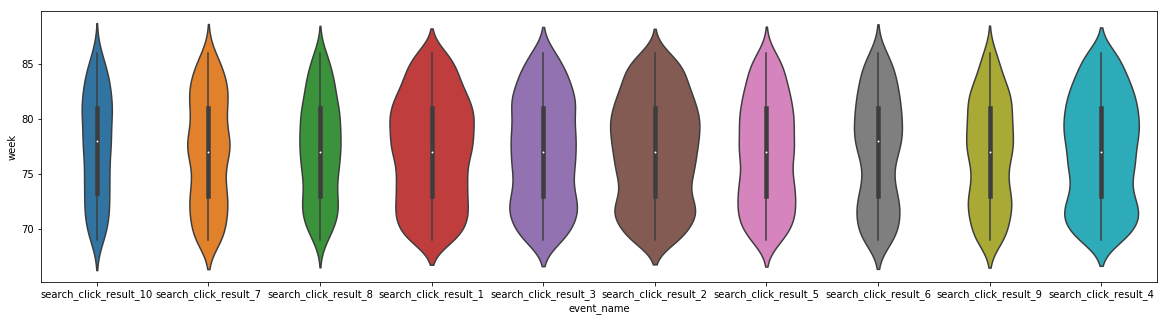

In [12]:
plt.figure(figsize=(20,5))
sns.violinplot(x = 'event_name', y = 'week',data = evt[(evt.event_type=='engagement') & (evt.evtname=='search_click_result')],scale="count")

#### Distribution among search_click_result_X seems to make sense.

Let's have a loot at the click rate of the search runs (#search_click_result/#search_run)

In [13]:
cr,bins=np.histogram(evt[evt.evtname=='search_click_result'].week,bins=range(evt.week.min(),evt.week.max()+2))
sr,bins=np.histogram(evt[evt.evtname=='search_run'].week,bins=range(evt.week.min(),evt.week.max()+2))

<BarContainer object of 18 artists>

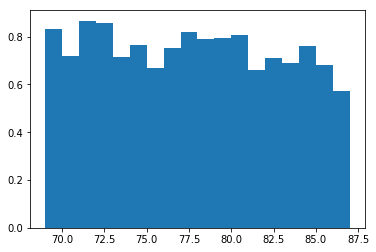

In [14]:
plt.bar(bins[:-1], cr/sr, align="edge", width=np.diff(bins))

seems to fall, search results aren't as good?

## Hypothesis 3: Langurage support? 

In [15]:
evt3=evt[evt.event_type=='engagement'].merge(pd.read_csv("yammer_users.csv")[["user_id","company_id","language"]],on='user_id')

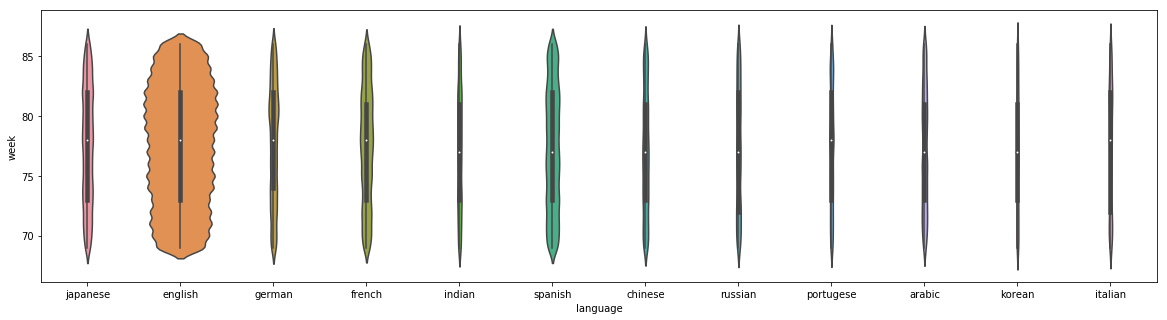

In [16]:
plt.figure(figsize=(20,5))
sns.violinplot(x = 'language', y = 'week',data = evt3,scale="count")

Nothing suspicious. Let's have a look at the companies instead.

## Hypothesis 4: Top client company left? 

(array([4.444e+03, 5.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([2.00000e+00, 1.91730e+03, 3.83260e+03, 5.74790e+03, 7.66320e+03,
        9.57850e+03, 1.14938e+04, 1.34091e+04, 1.53244e+04, 1.72397e+04,
        1.91550e+04]),
 <a list of 10 Patch objects>)

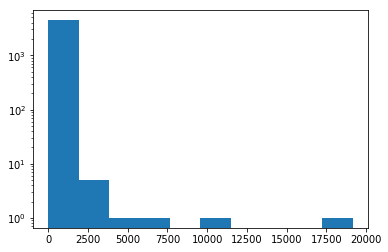

In [17]:
plt.hist(evt3.company_id.value_counts(),log=True)

In [18]:
evt3=evt3[evt3.groupby('company_id')['week'].transform('count')>1000]

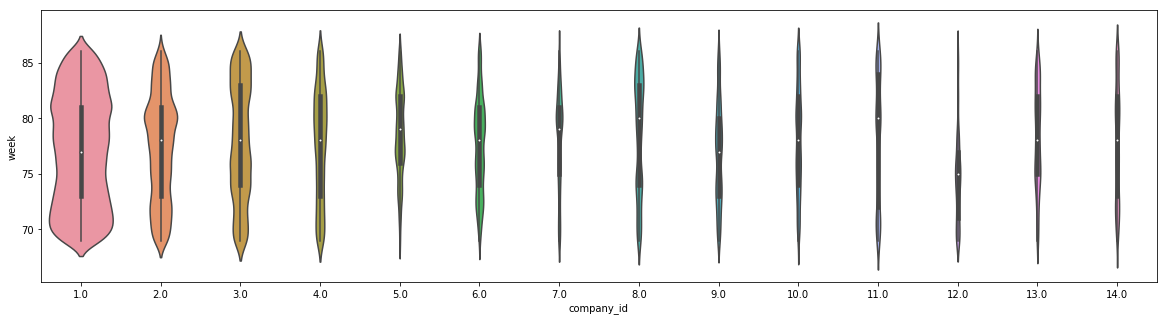

In [19]:
plt.figure(figsize=(20,5))
sns.violinplot(x = 'company_id', y = 'week',data = evt3,scale="count")

nothing obvious, usage drops in company 2 and 4, 5, 6, 7 etc at the same time.

## Hypothesis 5: Device support? 

(array([12.,  6.,  2.,  2.,  2.,  0.,  1.,  0.,  0.,  1.]),
 array([ 1786. ,  7274.4, 12762.8, 18251.2, 23739.6, 29228. , 34716.4,
        40204.8, 45693.2, 51181.6, 56670. ]),
 <a list of 10 Patch objects>)

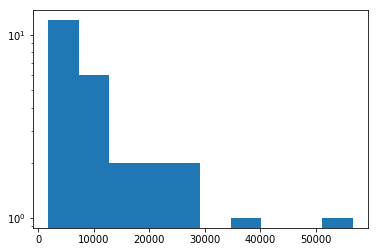

In [20]:
plt.hist(evt[evt.event_type=='engagement'].device.value_counts(),log=True)

In [21]:
evt4=evt[(evt.event_type=='engagement') & (evt.groupby('device')['week'].transform('count')>7000)]

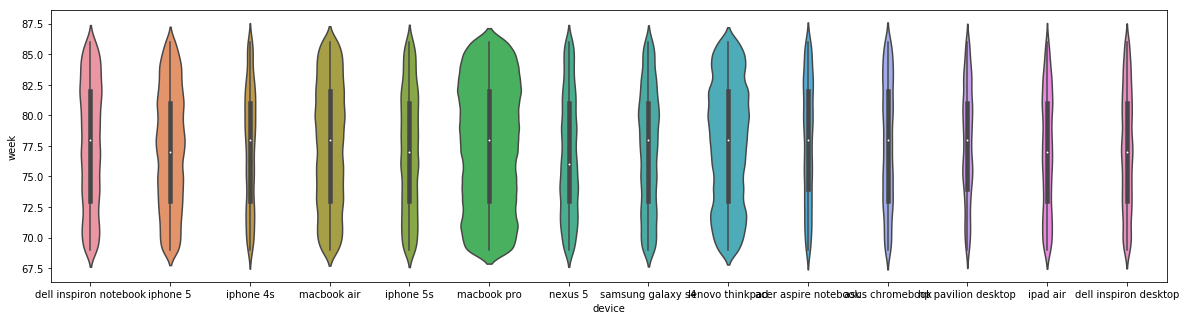

In [22]:
plt.figure(figsize=(20,5))
sns.violinplot(x = 'device', y = 'week',data = evt4,scale="count")

Interesting, usage drop is mainly from iphone, nexus5, samsung galaxy, all mobile devices. something is probably wrong with the mobile apps.

## Hypothesis 5.1: function problem with mobile app, especially searching result

In [23]:
evt5=evt[(evt.event_type=='engagement') & (evt.device.isin(['iphone 4s','iphone 5s','nexus 5','samsung galaxy s4']))]

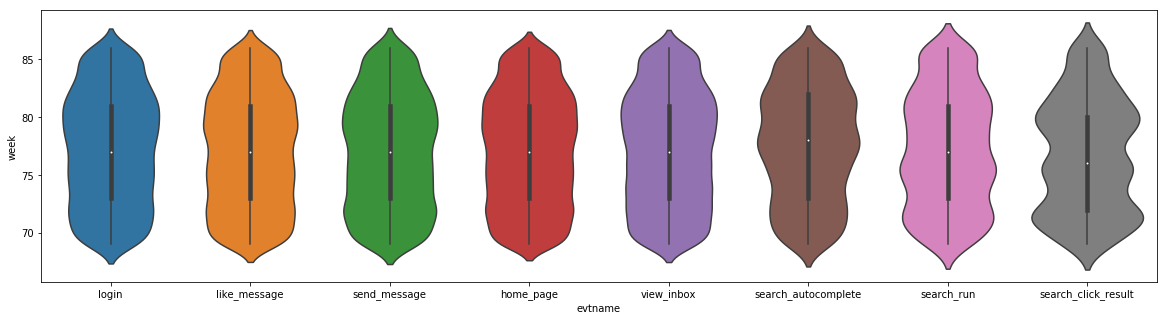

In [24]:
plt.figure(figsize=(20,5))
sns.violinplot(x = 'evtname', y = 'week',data = evt5)

something wrong with the searching result form these devices?

In [25]:
evt6=evt[(evt.event_type=='engagement') & (evt.device.isin(['macbook air','macbook pro']))]

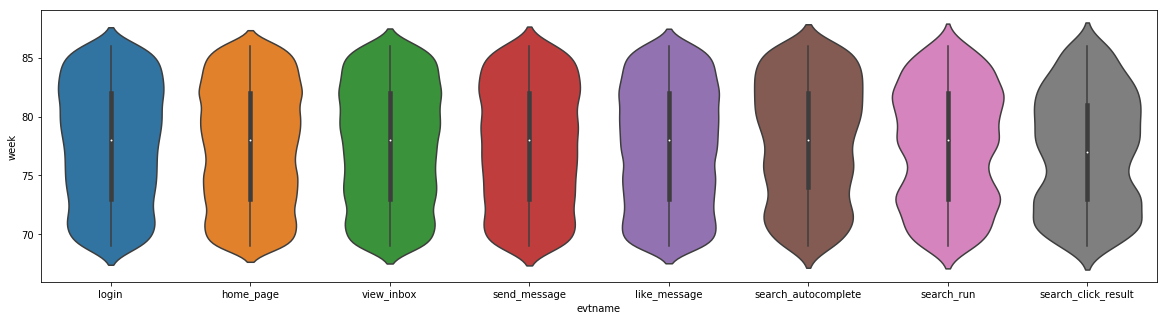

In [26]:
plt.figure(figsize=(20,5))
sns.violinplot(x = 'evtname', y = 'week',data = evt6)

Somehow the desktop apps also seem to have a drop in the click rate of the search runs, the searching result might not be the mobile app issue that causes the usage drop.

## Hypothesis 5.2: something with email

In [27]:
eml=pd.read_csv("yammer_emails.csv")

In [28]:
eml.head()

,user_id,occurred_at,action,user_type
0,0.0,2014-05-06 09:30:00,sent_weekly_digest,1.0
1,0.0,2014-05-13 09:30:00,sent_weekly_digest,1.0
2,0.0,2014-05-20 09:30:00,sent_weekly_digest,1.0
3,0.0,2014-05-27 09:30:00,sent_weekly_digest,1.0
4,0.0,2014-06-03 09:30:00,sent_weekly_digest,1.0


In [30]:
eml['time']=(pd.to_datetime(eml.occurred_at)-pd.to_datetime("2013-01-01 20:59:28")).dt.days

In [31]:
eml['week']=(eml.time)//7

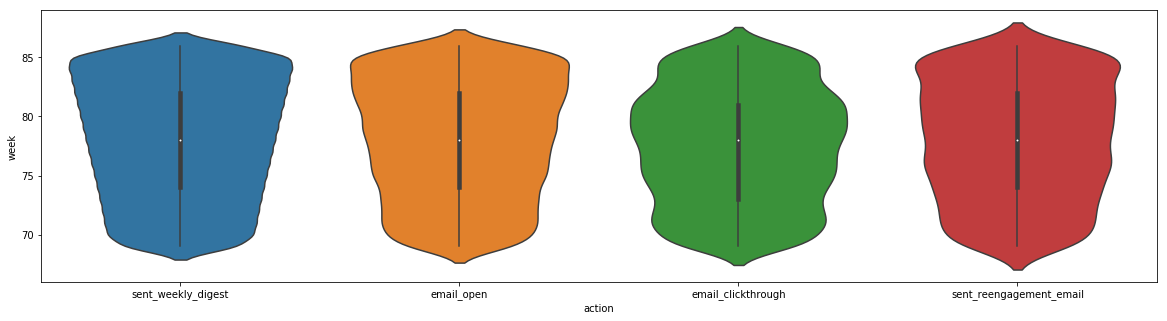

In [32]:
plt.figure(figsize=(20,5))
sns.violinplot(x = 'action', y = 'week',data = eml)

something could be wrong with email_clickthrough

# Conclusion: 
       - there could be something wrong with the email_clickthrough functionality in the mobile apps, which causes the usage drop.
       - it seems there's a drop in the click rate of the search runs, but it might not be the cause of the usage drop